In [1]:
import warnings
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
import numpy as np
import split_scale
from sklearn.preprocessing import StandardScaler, MinMaxScaler
#import wrangle
import env
import seaborn as sns
import acquire
import prepare
import explore
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, MinMaxScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import export_graphviz
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier

from graphviz import Source


Acquire and clean Data for modeling

In [99]:
url =acquire.get_db_url('telco_churn')

In [100]:
dfstart= acquire.prep_telco()

In [101]:
df= pd.DataFrame(dfstart)

In [102]:
df= df.drop (df[['internet_service_type_id', 'payment_type_id', 'contract_type_id', 'payment_type_id']], axis=1)

In [177]:
df.isnull().sum()

customer_id          0
gender               0
senior_citizen       0
partner              0
dependents           0
tenure               0
phone_service        0
online_security      0
device_protection    0
tech_support         0
streaming_tv         0
streaming_movies     0
paperless_billing    0
monthly_charges      0
total_charges        0
churn                0
contract_type        0
dtype: int64

In [105]:
df.dropna(inplace=True)

In [106]:
df= prepare.prep_telco(df)

In [107]:
df= df.drop(df[['multiple_lines', 'online_backup', 'payment_type', 'internet_service_type']], axis=1)

In [108]:

df['partner'] = df['partner'].replace({'Yes':1,'No':0})
df['dependents'] = df['dependents'].replace({'Yes':1,'No':0})
df['phone_service']= df ['phone_service'].replace({'Yes':1,'No':0})
df['online_security']= df['online_security'].replace({'Yes':1,'No':0,'No internet service':2})
df['device_protection']= df['device_protection'].replace({'Yes':1,'No':0,'No internet service':2})
df['tech_support']= df['tech_support'].replace({'Yes':1,'No':0,'No internet service':2})
df['streaming_tv']= df['streaming_tv'].replace({'Yes':1,'No':0,'No internet service':2})
df['streaming_movies']= df['streaming_movies'].replace({'Yes':1,'No':0,'No internet service':2})
df['paperless_billing']=df['paperless_billing'].replace({'Yes':1,'No':0})
df['gender']= df['gender'].replace({'Male':1,'Female':0})
df['contract_type']= df['contract_type'].replace({'Month-to-month':0,'One year':1,'Two year':2})
#df['internet_service_type']=df['internet_service_type].replace({'none':0, })


In [132]:
df= pd.DataFrame(df)

In [133]:
df.dtypes

customer_id           object
gender                 int64
senior_citizen         int64
partner                int64
dependents             int64
tenure                 int64
phone_service          int64
online_security        int64
device_protection      int64
tech_support           int64
streaming_tv           int64
streaming_movies       int64
paperless_billing      int64
monthly_charges      float64
total_charges        float64
churn                  int64
contract_type          int64
dtype: object

Split Data

In [134]:
train, test= split_scale.split_my_data(df, train_ratio=0.8, seed=123)

In [135]:
X = df[['tenure', 'contract_type', 'monthly_charges']]
y = df[['churn']]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .30, random_state = 123)

X_train.head()

,tenure,contract_type,monthly_charges
1479,52,1,68.75
2377,59,2,90.30
6613,46,2,20.25
6468,55,2,25.70
2668,10,0,79.95


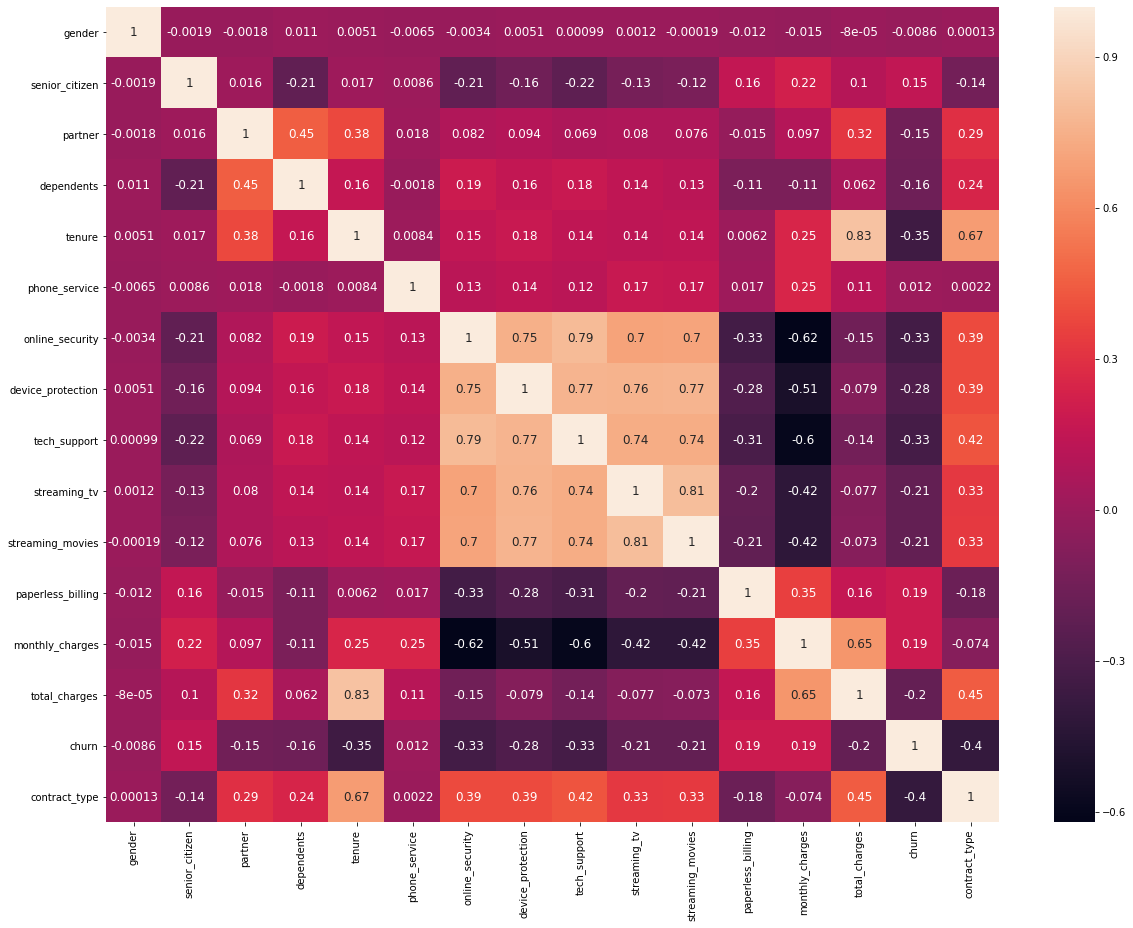

In [136]:
corr = df.corr()
sns.heatmap(corr, xticklabels=corr.columns.values, yticklabels=corr.columns.values, annot = True, annot_kws={'size':12})
heat_map=plt.gcf()
heat_map.set_size_inches(20,15)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.show()

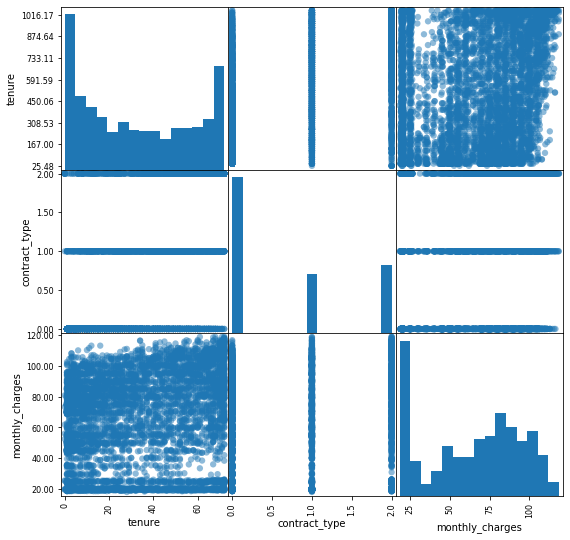

In [137]:
from matplotlib import cm
from matplotlib.ticker import FormatStrFormatter

cmap = cm.get_cmap('gnuplot')
axes = pd.plotting.scatter_matrix(
    train[['tenure', 'contract_type', 'monthly_charges']], marker='o', s=40,
    hist_kwds={'bins':15},  figsize=(9,9), cmap=cmap)
for ax in axes.flatten():
    ax.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))


# axes = pd.plotting.scatter_matrix(df, alpha=0.3, figsize=(9,9), diagonal='kde')
# for ax in axes.flatten():
#    ax.yaxis.set_major_formatter(FormatStrFormatter('%.2f')) 

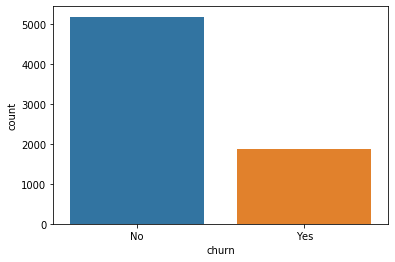

In [138]:
sns.countplot(x='churn', data=dfstart)

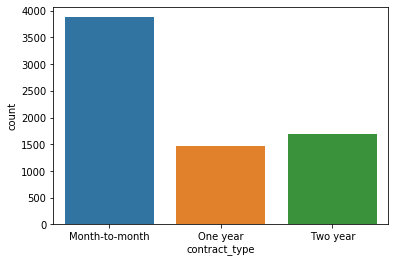

In [139]:
sns.countplot(x='contract_type', data=dfstart)
#plt.xlabel(0:'Month to month', 1:"1year", 2:"2year" )

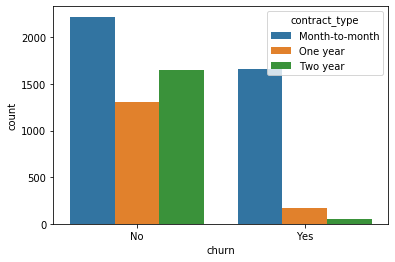

In [163]:
#distribution of contract types and whether customer churned 
sns.countplot(x='churn', data=dfstart, hue='contract_type')


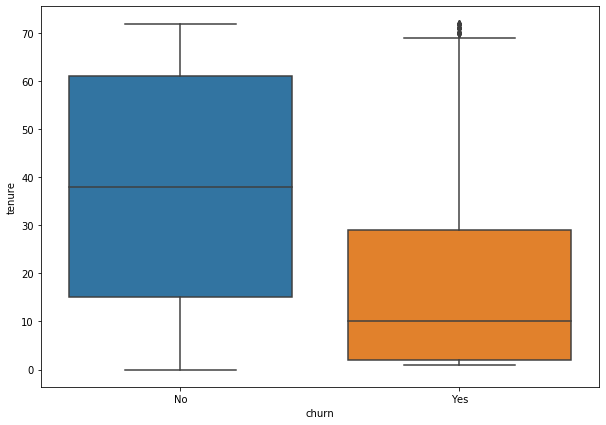

In [141]:

#Boxplot to show the distribution of ages. X is class, Y is age.
plt.figure(figsize = (10,7))
sns.boxplot(x='churn', y='tenure', data=dfstart)

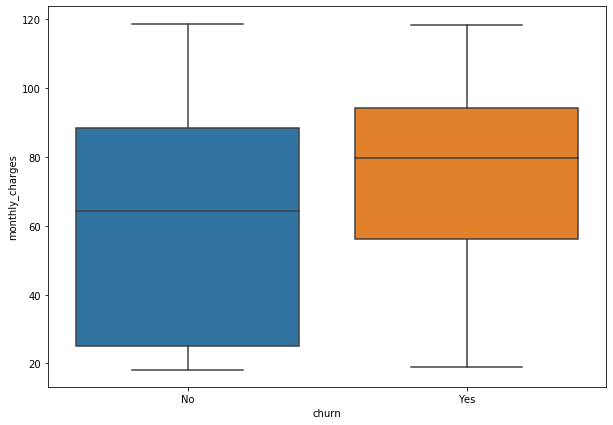

In [142]:
plt.figure(figsize = (10,7))
sns.boxplot(x='churn', y='monthly_charges', data=dfstart)

Train Model

Create the Decision Tree Object

# for classification you can change the algorithm to gini or entropy (information gain).  Default is gini.


In [164]:
clf = DecisionTreeClassifier(criterion='entropy', max_depth=4, random_state=123)

Fit the model to the training data



In [165]:
clf.fit(X_train, y_train)

DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=4,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=123, splitter='best')

Estimate Churn



In [166]:
y_pred = clf.predict(X_train)
y_pred[0:100]

array([0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0,
       1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

Estimate the probability of a species

In [167]:
y_pred_proba = clf.predict_proba(X_train)
y_pred_proba

array([[0.90666667, 0.09333333],
       [0.97807757, 0.02192243],
       [0.99388379, 0.00611621],
       ...,
       [0.90666667, 0.09333333],
       [0.55518764, 0.44481236],
       [0.55518764, 0.44481236]])

Evaluate Model

#Compute the Accuracy

#Accuracy: number of correct predictions over the number of total instances that have been evaluated.

In [168]:
print('Accuracy of Decision Tree classifier on training set: {:.2f}'
     .format(clf.score(X_train, y_train)))

Accuracy of Decision Tree classifier on training set: 0.79


Create a confusion matrix

True Positive: number of occurrences where y is true and y is predicted true.
True Negative: number of occurrences where y is false and y is predicted false.
False Positive: number of occurrences where y is false and y is predicted true.
False Negative: number of occurrences where y is true and y is predicted false.

In [169]:
confusion_matrix(y_train, y_pred)

array([[3334,  297],
       [ 762,  537]])

In [170]:
sorted(y_train.churn.unique())

[0, 1]

In [171]:
y_train.churn.value_counts()

0    3631
1    1299
Name: churn, dtype: int64

In [172]:
import pandas as pd

labels = sorted(y_train.churn.unique())

pd.DataFrame(confusion_matrix(y_train, y_pred), index=labels, columns=labels)

,0,1
0,3334,297
1,762,537


Create a classification report

Precision: the higher this number is, the more you were able to pinpoint all positives correctly. If this is a low score, you predicted a lot of positives where there were none. tp / (tp + fp)
Recall: if this score is high, you didn’t miss a lot of positives. But as it gets lower, you are not predicting the positives that are actually there. tp / (tp + fn)
f1-score: The balanced harmonic mean of Recall and Precision, giving both metrics equal weight. The higher the F-Measure is, the better.
Support: number of occurrences of each class in where y is true.

In [173]:
print(classification_report(y_train, y_pred))

              precision    recall  f1-score   support

           0       0.81      0.92      0.86      3631
           1       0.64      0.41      0.50      1299

    accuracy                           0.79      4930
   macro avg       0.73      0.67      0.68      4930
weighted avg       0.77      0.79      0.77      4930



#Test Model

#Compute the accuracy of the model when run on the test data

In [174]:
print('Accuracy of Decision Tree classifier on test set: {:.2f}'
     .format(clf.score(X_test, y_test)))

Accuracy of Decision Tree classifier on test set: 0.78


In [175]:
dot_data = export_graphviz(clf, out_file=None) 
graph = Source(dot_data) 

graph.render('telco_decision_tree', view=True)

'telco_decision_tree.pdf'

## Creating a CSV for the decision tree results

df_final = pd.concat(['customer_id',X_train, X_test])
df_final.shape

prediction = clf.predict(df_final)
# y_pred[0:50]
y_pred_proba = clf.predict_proba(df_final)
# y_pred_proba[:,1]
y_predictions = pd.DataFrame({'probability': y_pred_proba[:,1], 'predictions': (y_pred_proba[:,1] >= .5) == 1})
y_predictions = y_predictions.set_index(df.index)
y_predictions.to_csv(r'predictions.csv')

# MVP
will isolate the contract type to month to month

Acquire and Clean

In [40]:
dfmv= acquire.prep_telco_month()

In [41]:
dfmvp=pd.DataFrame(dfmv)

In [42]:
dfmvp= dfmvp.drop (dfmvp[['customer_id','internet_service_type_id', 'payment_type_id', 'contract_type_id', 'payment_type_id']], axis=1)

In [43]:
dfmvp.shape

(3875, 20)

In [44]:
dfmvp= dfmvp.drop (dfmvp[[ 'multiple_lines', 'online_backup', 'payment_type', 'internet_service_type', 'contract_type']], axis=1)

In [45]:
dfmvp['partner'] = dfmvp['partner'].replace({'Yes':1,'No':0})
dfmvp['dependents'] = dfmvp['dependents'].replace({'Yes':1,'No':0})
dfmvp['phone_service']= dfmvp ['phone_service'].replace({'Yes':1,'No':0})
dfmvp['online_security']= dfmvp['online_security'].replace({'Yes':1,'No':0,'No internet service':2})
dfmvp['device_protection']= dfmvp['device_protection'].replace({'Yes':1,'No':0,'No internet service':2})
dfmvp['tech_support']= dfmvp['tech_support'].replace({'Yes':1,'No':0,'No internet service':2})
dfmvp['streaming_tv']= dfmvp['streaming_tv'].replace({'Yes':1,'No':0,'No internet service':2})
dfmvp['streaming_movies']= dfmvp['streaming_movies'].replace({'Yes':1,'No':0,'No internet service':2})
dfmvp['paperless_billing']=dfmvp['paperless_billing'].replace({'Yes':1,'No':0})
dfmvp['gender']= dfmvp['gender'].replace({'Male':1,'Female':0})

In [46]:
dfmvp.head()

,gender,senior_citizen,partner,dependents,tenure,phone_service,online_security,device_protection,tech_support,streaming_tv,streaming_movies,paperless_billing,monthly_charges,total_charges,churn
0,0,1,0,0,7,1,1,0,0,0,0,1,48.20,340.35,No
1,1,1,0,0,1,0,0,0,0,0,0,1,25.10,25.1,Yes
2,1,1,0,0,2,1,1,0,0,0,0,1,49.25,91.1,Yes
3,0,0,1,0,6,1,0,0,0,0,0,0,50.35,314.55,No
4,1,0,1,0,22,1,1,0,1,0,0,1,54.20,1152.7,Yes


Graphs

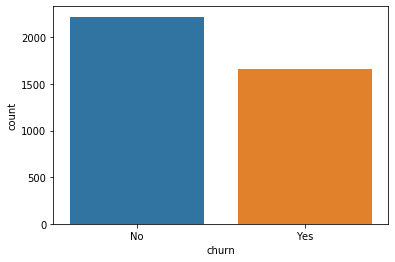

In [47]:
sns.countplot(x='churn', data=dfmvp)

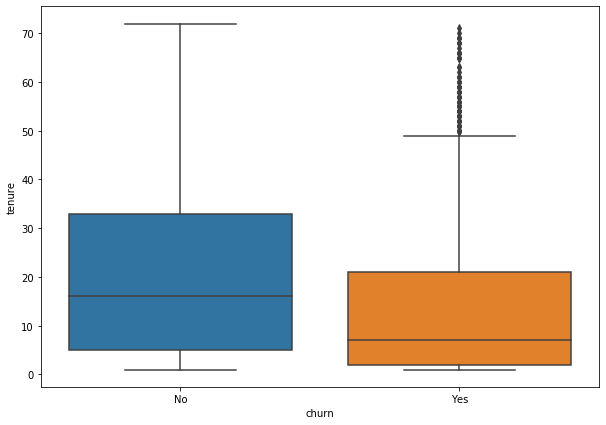

In [48]:
plt.figure(figsize = (10,7))
sns.boxplot(x='churn', y='tenure', data=dfmvp)

In [49]:
dfmvp.head()

,gender,senior_citizen,partner,dependents,tenure,phone_service,online_security,device_protection,tech_support,streaming_tv,streaming_movies,paperless_billing,monthly_charges,total_charges,churn
0,0,1,0,0,7,1,1,0,0,0,0,1,48.20,340.35,No
1,1,1,0,0,1,0,0,0,0,0,0,1,25.10,25.1,Yes
2,1,1,0,0,2,1,1,0,0,0,0,1,49.25,91.1,Yes
3,0,0,1,0,6,1,0,0,0,0,0,0,50.35,314.55,No
4,1,0,1,0,22,1,1,0,1,0,0,1,54.20,1152.7,Yes


In [50]:
train2, test2= split_scale.split_my_data(dfmvp, train_ratio=0.8, seed=123)

In [51]:
X2 = df[['gender','senior_citizen', 'partner', 'dependents', 'tenure', 'phone_service', 'online_security', 'device_protection', 'tech_support', 'streaming_tv', 'streaming_movies', 'paperless_billing', 'monthly_charges', 'total_charges',
    ]]
y2 = df[['churn']]
X_train2, X_test2, y_train2, y_test2 = train_test_split(X2, y2, test_size = .30, random_state = 123)

X_train2.head()

,gender,senior_citizen,partner,dependents,tenure,phone_service,online_security,device_protection,tech_support,streaming_tv,streaming_movies,paperless_billing,monthly_charges,total_charges
1479,1,0,1,1,52,1,0,1,1,1,0,1,68.75,3482.85
2377,0,0,1,1,59,1,1,1,1,1,1,0,90.30,5194.05
6613,0,0,1,1,46,1,2,2,2,2,2,0,20.25,890.35
6468,1,0,1,0,55,1,2,2,2,2,2,0,25.70,1443.65
2668,1,0,1,0,10,1,0,0,0,1,0,1,79.95,857.20


In [52]:
# for classification you can change the algorithm to gini or entropy (information gain).  Default is gini.
#Create the Decision Tree Object
clf2 = DecisionTreeClassifier(criterion='entropy', max_depth=3, random_state=123)

In [53]:
#Fit the model to the training data
clf2.fit(X_train2, y_train2)

DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=3,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=123, splitter='best')

#Estimate churn
y_pred2 = clf2.predict(X_train2)
y_pred2[0:100]

In [54]:
#Estimate the probability of a species

y_pred_proba2 = clf2.predict_proba(X_train2)
y_pred_proba2

array([[0.83567134, 0.16432866],
       [0.95724638, 0.04275362],
       [0.95724638, 0.04275362],
       ...,
       [0.95724638, 0.04275362],
       [0.681764  , 0.318236  ],
       [0.95724638, 0.04275362]])

Evaluate Model

Compute the Accuracy

Accuracy: number of correct predictions over the number of total instances that have been evaluated.

In [55]:
print('Accuracy of Decision Tree classifier on training set: {:.2f}'
     .format(clf2.score(X_train2, y_train2)))

Accuracy of Decision Tree classifier on training set: 0.79


Test Model

Compute the accuracy of the model when run on the test dataTest Model


In [56]:
print('Accuracy of Decision Tree classifier on test set: {:.2f}'
     .format(clf2.score(X_test2, y_test2)))

Accuracy of Decision Tree classifier on test set: 0.79


In [57]:
list_X = list(X_train2.columns)

In [58]:
MVP_tree_scores = dict(zip(list_X,clf2.feature_importances_))
MVP_tree_scores

{'gender': 0.0,
 'senior_citizen': 0.0,
 'partner': 0.0,
 'dependents': 0.0,
 'tenure': 0.36192691437406865,
 'phone_service': 0.0,
 'online_security': 0.49153442094409594,
 'device_protection': 0.0,
 'tech_support': 0.07324163413615202,
 'streaming_tv': 0.0,
 'streaming_movies': 0.0,
 'paperless_billing': 0.0,
 'monthly_charges': 0.07329703054568334,
 'total_charges': 0.0}

Variables used in MVP Calculation:
tenure
online_secuirty
tech_support
monthly _charges
total_charges

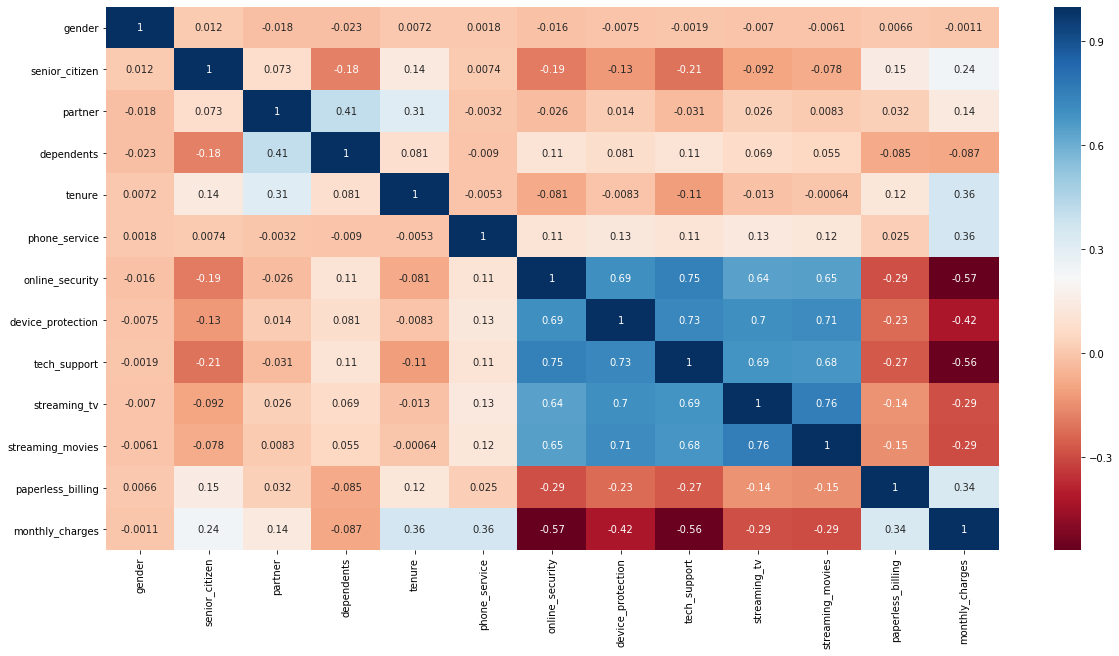

In [59]:
plt.figure(figsize=(20,10))
sns.heatmap(train2.corr(), annot = True, cmap ='RdBu')

## Logistic Regression
using MVP Data

In [60]:
X3 = df[['gender','senior_citizen', 'partner', 'dependents', 'tenure', 'phone_service', 'online_security', 'device_protection', 'tech_support', 'streaming_tv', 'streaming_movies', 'paperless_billing', 'monthly_charges', 'total_charges',
    ]]
y3 = df[['churn']]

X_train3, X_test3, y_train3, y_test3 = train_test_split(X3, y3, test_size = .30, random_state = 123)

X_train3.head()

,gender,senior_citizen,partner,dependents,tenure,phone_service,online_security,device_protection,tech_support,streaming_tv,streaming_movies,paperless_billing,monthly_charges,total_charges
1479,1,0,1,1,52,1,0,1,1,1,0,1,68.75,3482.85
2377,0,0,1,1,59,1,1,1,1,1,1,0,90.30,5194.05
6613,0,0,1,1,46,1,2,2,2,2,2,0,20.25,890.35
6468,1,0,1,0,55,1,2,2,2,2,2,0,25.70,1443.65
2668,1,0,1,0,10,1,0,0,0,1,0,1,79.95,857.20


In [61]:
#Create the logistic regression object
logit = LogisticRegression(C=1, class_weight={1:2}, random_state = 123, solver='saga')

In [62]:
#Fit the model to the training data

logit.fit(X_train3, y_train3)

LogisticRegression(C=1, class_weight={1: 2}, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=123, solver='saga', tol=0.0001, verbose=0,
                   warm_start=False)

In [63]:
#Print the coefficients and intercept of the model

print('Coefficient: \n', logit.coef_)
print('Intercept: \n', logit.intercept_)

Coefficient: 
 [[-0.00029599  0.00034558 -0.00041937 -0.00064478 -0.02751851 -0.00057114
  -0.00212654 -0.00172416 -0.00209518 -0.00145422 -0.00141806  0.00033154
   0.01450475 -0.00017265]]
Intercept: 
 [-0.00067291]


In [64]:
#Estimate whether or not a customer will churn, using the training data

y_pred3 = logit.predict(X_train3)

In [65]:
#Estimate the probability of a passenger surviving, using the training data

y_pred_proba3 = logit.predict_proba(X_train3)

In [66]:
#Evaluate Model

#Compute the accuracy

print('Accuracy of Logistic Regression classifier on training set: {:.2f}'
     .format(logit.score(X_train3, y_train3)))

Accuracy of Logistic Regression classifier on training set: 0.70


In [67]:
#Create a confusion matrix

print(confusion_matrix(y_train3, y_pred3))

[[2500 1131]
 [ 347  952]]


In [68]:
#Compute Precision, Recall, F1-score, and Support

print(classification_report(y_train3, y_pred3))

              precision    recall  f1-score   support

           0       0.88      0.69      0.77      3631
           1       0.46      0.73      0.56      1299

    accuracy                           0.70      4930
   macro avg       0.67      0.71      0.67      4930
weighted avg       0.77      0.70      0.72      4930



In [69]:
#Test Model

#Compute the accuracy of the model when run on the test data

print('Accuracy of Logistic Regression classifier on test set: {:.2f}'
     .format(logit.score(X_test3, y_test3)))

Accuracy of Logistic Regression classifier on test set: 0.71


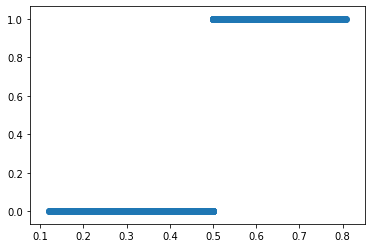

In [70]:
## verify
y_pred_proba3 = [i[1] for i in y_pred_proba3]
fig = plt.figure()
ax = fig.add_subplot(111)
ax.scatter(y_pred_proba3, y_pred3)

## KNN

In [71]:
X4 = df[['gender','senior_citizen', 'partner', 'dependents', 'tenure', 'phone_service', 'online_security', 'device_protection', 'tech_support', 'streaming_tv', 'streaming_movies', 'paperless_billing', 'monthly_charges', 'total_charges',
    ]]
y4 = df[['churn']]

X_train4, X_test4, y_train4, y_test4 = train_test_split(X4, y4, test_size = .30, random_state = 123)

X_train4.head()

,gender,senior_citizen,partner,dependents,tenure,phone_service,online_security,device_protection,tech_support,streaming_tv,streaming_movies,paperless_billing,monthly_charges,total_charges
1479,1,0,1,1,52,1,0,1,1,1,0,1,68.75,3482.85
2377,0,0,1,1,59,1,1,1,1,1,1,0,90.30,5194.05
6613,0,0,1,1,46,1,2,2,2,2,2,0,20.25,890.35
6468,1,0,1,0,55,1,2,2,2,2,2,0,25.70,1443.65
2668,1,0,1,0,10,1,0,0,0,1,0,1,79.95,857.20


In [72]:
#Train Model

#Create KNN Object

# weights = ['uniform', 'density']
knn = KNeighborsClassifier(n_neighbors=5, weights='uniform')

In [73]:
#Fit the model to the training data

knn.fit(X_train4, y_train4)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                     weights='uniform')

In [74]:
#Estimate whether or not a passenger would survive, using the training data

y_pred4 = knn.predict(X_train4)

In [75]:
#Estimate the probability of a passenger surviving, using the training data

y_pred_proba4 = knn.predict_proba(X_train4)

In [76]:
#Evaluate Model

#Compute the accuracy

print('Accuracy of KNN classifier on training set: {:.2f}'
     .format(knn.score(X_train4, y_train4)))

Accuracy of KNN classifier on training set: 0.83


In [77]:
#Create a confusion matrix

print(confusion_matrix(y_train4, y_pred4))

[[3383  248]
 [ 579  720]]


In [78]:
#Compute Precision, Recall, F1-score, and Support

print(classification_report(y_train4, y_pred4))

              precision    recall  f1-score   support

           0       0.85      0.93      0.89      3631
           1       0.74      0.55      0.64      1299

    accuracy                           0.83      4930
   macro avg       0.80      0.74      0.76      4930
weighted avg       0.82      0.83      0.82      4930



In [79]:
#Test Model

#Compute the accuracy of the model when run on the test data
print('Accuracy of KNN classifier on test set: {:.2f}'
     .format(knn.score(X_test4, y_test4)))

Accuracy of KNN classifier on test set: 0.76


# EXPORE

## 1: Could the month in which they signed up influence churn? i.e. if a cohort is identified by tenure, is there a cohort or cohorts who have a higher rate of churn than other cohorts? (Plot the rate of churn on a line chart where x is the tenure and y is the rate of churn (customers churned/total customers)

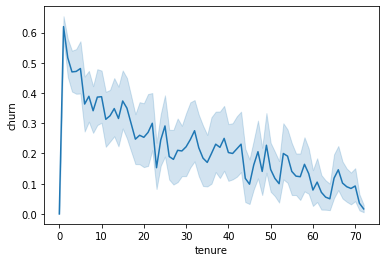

In [80]:
sns.lineplot(x="tenure", y='churn', data=df)
plt.show()

"Customers" are more of prospects when they are under month to month contract, especially in the first six months. 
It is inconclusive on whether there is a specific month where churn will occur, but we can conlcude the first 8 months is 
time period where churn most occurs in this customer base.

## 2:Are there features that indicate a higher propensity to churn? like type of internet service, type of phone service, online security and backup, senior citizens, paying more than x% of customers with the same services, etc.?

In [81]:
meanmc= df['monthly_charges'].mean()

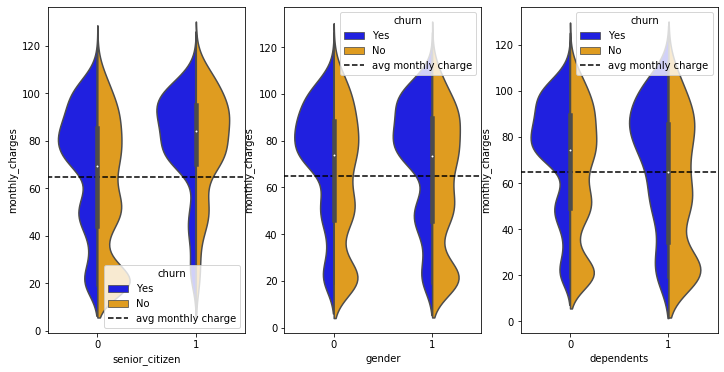

In [82]:
# 3. violin plot
features = ['senior_citizen', 'gender', 'dependents']
_, ax = plt.subplots(nrows=1, ncols=3, figsize=(12,6))


for i, feature in enumerate(features):
    ax[i].hlines(meanmc,-1,2, label= "avg monthly charge", ls= "--", color= 'black')
    sns.violinplot(feature, 'monthly_charges', hue='churn',
        data=train2, split=True, ax=ax[i], palette=['blue','orange'])


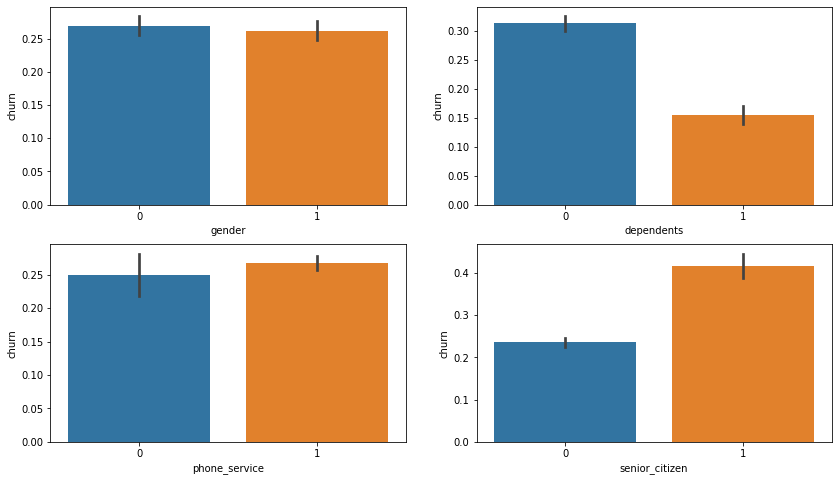

In [83]:
plt.figure(figsize=(14,8))

plt.subplot(2,2,1)
sns.barplot(x="gender", y="churn", data=df)

plt.subplot(2,2,2)
sns.barplot(x="dependents", y="churn", data=df)

plt.subplot(2,2,3)
sns.barplot(x="phone_service", y="churn", data=df)

plt.subplot(2,2,4)
sns.barplot(x="senior_citizen", y="churn", data=df)


## 3. Is there a price threshold for specific services where the likelihood of churn increases once price for those services goes past that point? If so, what is that point for what service(s)?

In [85]:
dfmvp.head()

,gender,senior_citizen,partner,dependents,tenure,phone_service,online_security,device_protection,tech_support,streaming_tv,streaming_movies,paperless_billing,monthly_charges,total_charges,churn
0,0,1,0,0,7,1,1,0,0,0,0,1,48.20,340.35,No
1,1,1,0,0,1,0,0,0,0,0,0,1,25.10,25.1,Yes
2,1,1,0,0,2,1,1,0,0,0,0,1,49.25,91.1,Yes
3,0,0,1,0,6,1,0,0,0,0,0,0,50.35,314.55,No
4,1,0,1,0,22,1,1,0,1,0,0,1,54.20,1152.7,Yes


### 4.If we looked at churn rate for month-to-month customers after the 12th month and that of 1-year contract customers after the 12th month, are those rates comparable?

In [86]:
df1year= acquire.prep_telco_1year()


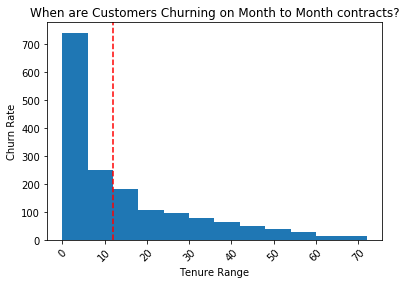

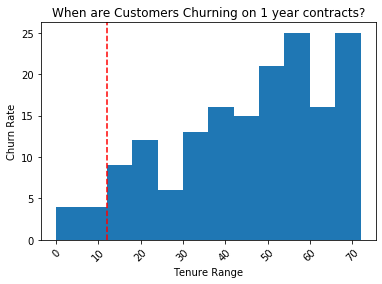

In [87]:
#Month to Month vs one year Contracts
bins = [0,6,12,18,24,30,36,42,48,54,60,66,72]
plt.hist('tenure', data = dfmvp[dfmvp.churn == 'Yes'], alpha = 1, bins = bins)

plt.ylabel('Churn Rate')
plt.xlabel('Tenure Range')
plt.xticks(rotation = 45)
plt.title('When are Customers Churning on Month to Month contracts?')
plt.axvline(x=12, ls='--', color='red')
plt.show()


bins = [0,6,12,18,24,30,36,42,48,54,60,66,72]
plt.hist('tenure', data = df1year[df1year.churn == 'Yes'], alpha = 1, bins = bins)

plt.ylabel('Churn Rate')
plt.xlabel('Tenure Range')
plt.xticks(rotation = 45)
plt.title('When are Customers Churning on 1 year contracts?')
plt.axvline(x=12, ls='--', color='red')
plt.show()



The rate of churn are not comparable, the churn rate for Mopnth to Mopnth contracts decreases dramatically after month 12 while the exact opposite hold true for one year contracts.

## Creating a CSV for the decision tree results


In [88]:
df_final = pd.concat([numeric_X_train, numeric_X_test])
df_final.shape
prediction = clf.predict(df_final)
# y_pred[0:50]
y_pred_proba = clf.predict_proba(df_final)
# y_pred_proba[:,1]
y_predictions = pd.DataFrame({'probability': y_pred_proba[:,1], 'predictions': (y_pred_proba[:,1] >= .5) == 1})
y_predictions = y_predictions.set_index(df.index)
y_predictions.to_csv(r'DT_probability_and_predictions.csv')

NameError: name 'numeric_X_train' is not defined